<a href="https://colab.research.google.com/github/ChaithanyaSaiB/UMBC-DATA606-Capstone/blob/main/notebooks/Exploration_and_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

In [51]:
data = pd.read_csv('/content/cnnhealth_transformed_second_edit.csv')
data

,Unnamed: 0,Content
0,0,wa child pale specter use even eager doctor fa...
1,1,hey dude music say wear take note probabl hear...
2,2,outer protect garment may led strain bacteria ...
3,3,nation health said plan health care worker per...
4,4,may iron man popular marvel superhero film rec...
...,...,...
644,644,follow diet may us news world report week publ...
645,645,person brain dead may may heartbeat may like b...
646,646,follow diet may us news world report week publ...
647,647,fisher small hi age look though hi athletic ai...


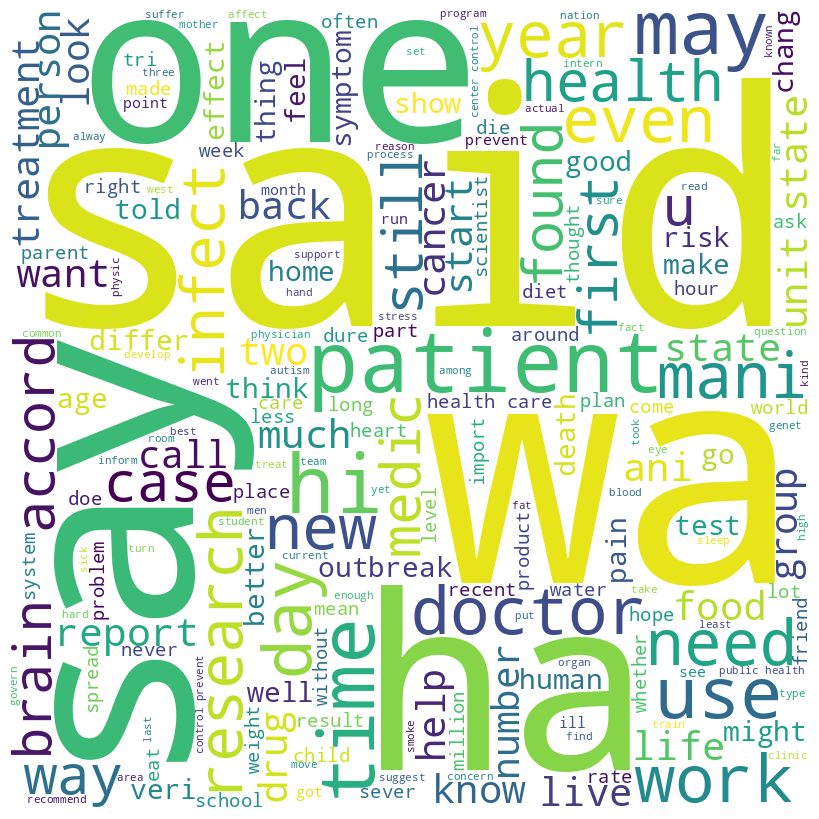

In [52]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(data['Content'].str.cat(sep = ' '))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [53]:
vectorizer = CountVectorizer()
data_transformed = vectorizer.fit_transform(data['Content'])
data_transformed = pd.DataFrame(data_transformed.toarray(), columns=vectorizer.get_feature_names_out(), index=data.index)
data_transformed

,abandon,abbey,abdomen,abnormality,aboard,abort,abound,about,above,abroad,...,zing,zip,zipper,zoll,zombi,zone,zoo,zoom,zoster,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
data_transformed.stack().value_counts().sort_index()

0     3654465
1       74912
2       17945
3        6655
4        3276
5        1779
6        1090
7         682
8         496
9         331
10        219
11        170
12        187
13        103
14         96
15         57
16         59
17         59
18         44
19         50
20         24
21         43
22         22
23         17
24         11
25         18
26         11
27          6
28          9
29          7
30          7
31          8
32          4
33          3
34          5
35          3
36          6
37          2
39          4
40          1
41          3
43          1
44          4
45          1
46          1
51          2
52          1
63          1
69          1
70          1
dtype: int64

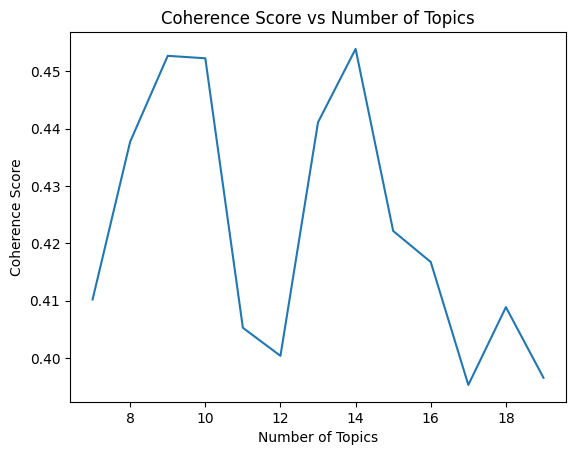

In [55]:
# Tokenize documents
tokenized_documents = [doc.split() for doc in data['Content']]

# Create a dictionary from the tokenized documents
dictionary = corpora.Dictionary(tokenized_documents)

# Create a corpus from the tokenized documents
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Set range of topics to explore
min_topics = 7
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Run LDA model for different number of topics and compute coherence score
coherence_scores = []
for num_topics in topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plot coherence score vs number of topics
plt.plot(topics_range, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()


In [57]:
# Split data into training and validation sets
train_corpus, val_corpus = train_test_split(corpus, test_size=0.2, random_state=42)

# Define hyperparameters grid
params_grid = {
    'alpha': ['auto', 'symmetric', 'asymmetric'],  # Alpha parameter
    'eta': ['auto', 0.01, 0.1]  # Eta parameter
}

best_model = None
best_coherence_score = -float('inf')

# Perform grid search
for params in ParameterGrid(params_grid):
    print("Trying parameters:", params)
    lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=9, update_every=1, chunksize=100, passes=10, **params)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print("Coherence Score:", coherence_score)

    # Update best model if coherence score improves
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score

print("Best Model Parameters:", best_model.get_topics())
print("Best Coherence Score:", best_coherence_score)

Trying parameters: {'alpha': 'auto', 'eta': 'auto'}
Coherence Score: 0.3477999637847232
Trying parameters: {'alpha': 'auto', 'eta': 0.01}
Coherence Score: 0.38036979654393666
Trying parameters: {'alpha': 'auto', 'eta': 0.1}
Coherence Score: 0.38229181979949817
Trying parameters: {'alpha': 'symmetric', 'eta': 'auto'}
Coherence Score: 0.3891790829700357
Trying parameters: {'alpha': 'symmetric', 'eta': 0.01}
Coherence Score: 0.4001036930929475
Trying parameters: {'alpha': 'symmetric', 'eta': 0.1}
Coherence Score: 0.37642845272210695
Trying parameters: {'alpha': 'asymmetric', 'eta': 'auto'}
Coherence Score: 0.381086740272373
Trying parameters: {'alpha': 'asymmetric', 'eta': 0.01}
Coherence Score: 0.3752138620780089
Trying parameters: {'alpha': 'asymmetric', 'eta': 0.1}
Coherence Score: 0.37522940585202424
Best Model Parameters: [[1.3024070e-06 4.8844218e-03 1.3024091e-06 ... 1.3024069e-06
  1.3024069e-06 1.3024069e-06]
 [5.3701183e-07 9.2526348e-03 1.5499667e-03 ... 5.3698511e-07
  5.36985

In [58]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=9, update_every=1, chunksize=100, passes=10, alpha='symmetric', eta=0.01, random_state=100)

# Print topics
pprint(lda_model.print_topics())


[(0,
  '0.268*"pain" + 0.059*"back" + 0.036*"leg" + 0.035*"strength" + '
  '0.030*"proper" + 0.027*"arm" + 0.027*"breath" + 0.021*"chest" + 0.019*"hip" '
  '+ 0.019*"movement"'),
 (1,
  '0.092*"food" + 0.078*"diet" + 0.060*"weight" + 0.052*"eat" + 0.022*"fat" + '
  '0.021*"product" + 0.020*"sugar" + 0.017*"fruit" + 0.016*"day" + '
  '0.016*"loss"'),
 (2,
  '0.020*"care" + 0.018*"state" + 0.016*"report" + 0.016*"ha" + 0.016*"health" '
  '+ 0.015*"said" + 0.015*"patient" + 0.014*"year" + 0.013*"say" + '
  '0.012*"medic"'),
 (3,
  '0.047*"said" + 0.026*"health" + 0.023*"patient" + 0.022*"case" + 0.020*"ha" '
  '+ 0.019*"infect" + 0.016*"wa" + 0.014*"outbreak" + 0.013*"state" + '
  '0.012*"symptom"'),
 (4,
  '0.026*"cancer" + 0.024*"use" + 0.024*"drug" + 0.015*"said" + 0.012*"accord" '
  '+ 0.012*"say" + 0.012*"cell" + 0.012*"smoke" + 0.012*"research" + '
  '0.012*"marijuana"'),
 (5,
  '0.066*"brain" + 0.044*"research" + 0.021*"may" + 0.019*"said" + 0.019*"say" '
  '+ 0.019*"found" + 0.015

**Topics and their keywords**

1. **Pain Management**:
  pain, back, leg, strength, proper, arm, breath, chest, hip, movement
2. **Diet and Weight Management**:
  food, diet, weight, eat, fat, product, sugar, fruit, day, loss
3. **Healthcare and Medical Reports**:
  care, state, report, health, said, patient, year, say, medic
4. **Health Concerns and Infectious Diseases**:
  said, health, patient, case, ha, infect, wa, outbreak, state, symptom
5. **Cancer Research and Drug Use**:
  cancer, use, drug, said, accord, say, cell, smoke, research, marijuana
6. **Brain Research and Findings**:
  brain, research, may, said, say, found, age, autism, show, differ
7. **General Life and Time Management**:
  wa, hi, time, day, would, say, one, like, life, year
8. **Miscellaneous Topics (Unclear)**:
  cox, clean, camp, dog, car, jordan, matter, fear, fact, opinion
9. **Parenting and Adolescent Issues**:
  said, parent, child, wa, depress, survivor, teen, sexual, help, sex

In [59]:
document_topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]
for i, doc_topics in enumerate(document_topic_distribution):
    print(f"Document {i}: {doc_topics}")

Document 0: [(1, 0.047222063), (2, 0.2346501), (3, 0.055560783), (4, 0.11498547), (5, 0.032544233), (6, 0.36398658), (8, 0.15044934)]
Document 1: [(2, 0.21156953), (3, 0.045024462), (4, 0.10060021), (5, 0.02031276), (6, 0.58635676), (8, 0.034728575)]
Document 2: [(3, 0.62836295), (4, 0.36595455)]
Document 3: [(3, 0.9661935), (8, 0.022521943)]
Document 4: [(0, 0.10045471), (2, 0.21094076), (3, 0.05781888), (4, 0.045372717), (5, 0.11779859), (6, 0.46563977)]
Document 5: [(2, 0.04276853), (3, 0.11253415), (4, 0.14754805), (5, 0.35018423), (6, 0.26771036), (7, 0.077816136)]
Document 6: [(3, 0.81983757), (4, 0.16836825)]
Document 7: [(1, 0.047221985), (2, 0.23465317), (3, 0.055556946), (4, 0.114986174), (5, 0.032543216), (6, 0.3639861), (8, 0.15045096)]
Document 8: [(2, 0.16701975), (5, 0.02919054), (6, 0.7844533)]
Document 9: [(0, 0.014430297), (1, 0.023477722), (2, 0.19065061), (5, 0.1981725), (6, 0.5307155), (7, 0.039925683)]
Document 10: [(0, 0.029669598), (2, 0.092460304), (6, 0.818796

In [60]:
topic_names = [
    "Pain Management",
    "Diet and Weight Management",
    "Healthcare and Medical Reports",
    "Health Concerns and Infectious Diseases",
    "Cancer Research and Drug Use",
    "Brain Research and Findings",
    "General Life and Time Management",
    "Miscellaneous Topics (Unclear)",
    "Parenting and Adolescent Issues"
]


# Initialize defaultdict to store topic frequencies
topic_frequencies = defaultdict(float)

# Aggregate probabilities for each topic across all documents
for doc_topics in document_topic_distribution:
    for topic, prob in doc_topics:
        topic_frequencies[topic] += prob

# Calculate frequencies by dividing the aggregated probabilities by the number of documents
num_documents = len(document_topic_distribution)
topic_frequencies = {topic: freq / num_documents for topic, freq in topic_frequencies.items()}

sorted_topic_frequencies = sorted(topic_frequencies.items())
topic_frequencies = [tup[1] for tup in sorted_topic_frequencies]

for topic, value in zip(topic_names,topic_frequencies):
  print("{} topic has {:.2f} average probability in documents".format(topic, value))

Pain Management topic has 0.01 average probability in documents
Diet and Weight Management topic has 0.04 average probability in documents
Healthcare and Medical Reports topic has 0.18 average probability in documents
Health Concerns and Infectious Diseases topic has 0.21 average probability in documents
Cancer Research and Drug Use topic has 0.14 average probability in documents
Brain Research and Findings topic has 0.07 average probability in documents
General Life and Time Management topic has 0.29 average probability in documents
Miscellaneous Topics (Unclear) topic has 0.02 average probability in documents
Parenting and Adolescent Issues topic has 0.04 average probability in documents


In [61]:
import plotly.graph_objects as go

# Create horizontal bar chart
fig = go.Figure(go.Bar(
    x=topic_frequencies,
    y=topic_names,
    orientation='h'
))

# Customize layout
fig.update_layout(
    title='Topics and their average probabilities',
    xaxis_title='Probabilities',
    yaxis_title='Topics',
    yaxis=dict(autorange='reversed', tickmode='linear')  # Reverse the order of categories for horizontal bar chart
)

# Show plot
fig.show()
